# <mark>Attention!</mark>

This project was originally made in the Russian language. It takes quite a lot of effort to manually translate everything into English. So in order to understand what is going on here, **please use an automatic Google page translator**. It does a pretty decent job!

# Проект по исследованию метрик тарифных планов оператора мобильной связи
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов
**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

# Импортируем библиотеки и открываем датасеты
<a id="Открытие-данных"></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# file loading for Windows
try: 
    
    calls = pd.read_csv('datasets/calls.csv')
    internet = pd.read_csv('datasets/internet.csv')
    messages = pd.read_csv('datasets/messages.csv')
    tariffs = pd.read_csv('datasets/tariffs.csv')
    users = pd.read_csv('datasets/users.csv')
    
# file loading for Linux(?)    
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')

# Первичная обработка данных
<a id="Первичная-обработка-данных"></a>

## Приведение к нужным типам, нахождение и исправление ошибок
<a id="Приведение-к-нужным-типам"></a>

Заменим тип данных колонки `user_id` во всех датафреймах с `int64` на тип `int16` если макс. значение `user_id` меньше 132767 (макс. значение `int16`). Это позволит сэкономить память, время и ресурсы.

In [3]:
for dataframe in [calls, users, internet, messages]:
    if dataframe['user_id'].max() < 132767: # max int16 value
        dataframe['user_id'] = dataframe['user_id'].astype('int16')
    

### Таблица `users` (информация о пользователях):

- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tarif` — название тарифного плана

In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int16 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int16(1), int64(1), object(6)
memory usage: 28.4+ KB


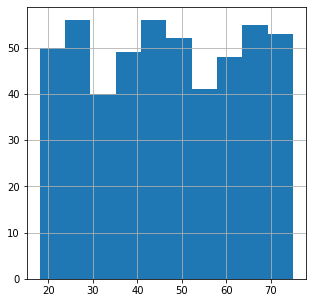

In [6]:
users.age.hist(figsize=(5, 5))
plt.show()

Приведём тип данных колонок `reg_date` и `churn_date` к типу `DateTime`

In [7]:
users.reg_date = pd.to_datetime(users.reg_date)

In [8]:
users.churn_date = pd.to_datetime(users.churn_date)

Приведём тип данных колонки `age` к `int8`

In [9]:
users.age.max()

75

In [10]:
users.age = users.age.astype('int8')

**Промежуточный вывод:** колонки `reg_date` и `churn_date` были приведены к типу `DateTime`, колонка `user_id` приведена к типу `int16`, колонка `age` приведена к типу `int8`.

### Таблица `calls` (информация о звонках)
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

In [11]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


**Важно:** Нулями обозначены пропущенные звонки, поэтому их не нужно удалять

In [12]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int16  
dtypes: float64(1), int16(1), object(2)
memory usage: 5.0+ MB


Приведём тип данных колонки `call_date` к типу `DateTime`

In [13]:
calls.call_date = pd.to_datetime(calls.call_date)

Округлим значения по длительности звонков и приведём к целочисельному типу `int8`.

In [14]:
calls.duration.max()

38.0

In [15]:
calls.duration = np.ceil(calls.duration).astype('int8')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


**Промежуточный вывод:** колонка `call_date` была приведена к типу `DateTime`, длительность звонков была округлена в большую сторону и приведена к целочисельному типу.

### Таблица internet (информация об интернет-сессиях):

- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

In [16]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int16  
dtypes: float64(1), int16(1), int64(1), object(2)
memory usage: 4.8+ MB


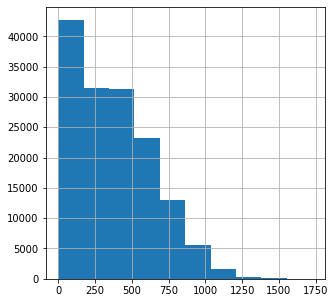

In [18]:
internet.mb_used.hist(figsize=(5, 5))
plt.show()

Приведём тип данных колонки `session_date` к типу `DateTime`

In [19]:
internet.session_date = pd.to_datetime(internet.session_date)

**Промежуточный вывод:** особых проблем не обнаружено, колонка `session_date` была приведена к типу `DateTime`, ненужная колонка была удалена.

### Таблица `messages` (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

In [20]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [21]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int16 
dtypes: int16(1), object(2)
memory usage: 2.1+ MB


Приведём тип данных колонки `message_date` к типу `DateTime`

In [22]:
messages.message_date = pd.to_datetime(messages.message_date)

**Промежуточный вывод:** колонка `message_date` была приведена к типу `DateTime`.

### Таблица `tariffs` (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [23]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Посчитаем для каждого пользователя:

### Количество сделанных звонков и израсходованных минут разговора по месяцам;

In [24]:
calls['month'] = calls.call_date.dt.month
calls_monthly = calls.groupby(['user_id', 'month'])['duration'].agg(['sum', 'count'])
calls_monthly.rename(columns={'sum': 'minutes', 'count': 'calls'}, inplace=True)
calls_monthly.head()

minutes  calls
user_id month                
1000    5        159.0     22
        6        172.0     43
        7        340.0     47
        8        408.0     52
        9        466.0     58

In [25]:
#pd.pivot_table(data=calls, index='user_id', columns='call_month', values='duration', aggfunc=['sum', 'count'])

### Количество отправленных сообщений по месяцам;

In [26]:
messages['month'] = messages.message_date.dt.month
messages_monthly = messages.groupby(['user_id', 'month'])['id'].agg(['count'])
messages_monthly.rename(columns={'count': 'messages'}, inplace=True)
messages_monthly.head()

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57

### Объем израсходованного интернет-трафика по месяцам

In [27]:
internet['month'] = internet.session_date.dt.month

In [28]:
internet_monthly = internet.groupby(['user_id', 'month'])[['mb_used']].sum()
internet_monthly.mb_used  = internet_monthly.mb_used.astype('int64')
internet_monthly.head()

mb_used
user_id month         
1000    5         2253
        6        23233
        7        14003
        8        14055
        9        14568

Округлим месячное потребление трафика до гигабайт

In [29]:
def roundup(x):
    return int(np.ceil(x / 1000.0)) * 1

internet_monthly.mb_used = internet_monthly.mb_used.apply(lambda x: roundup(x))
internet_monthly = internet_monthly.reset_index()
internet_monthly.rename(columns={'mb_used': 'internet'}, inplace=True)
internet_monthly.head()

,user_id,month,internet
0,1000,5,3
1,1000,6,24
2,1000,7,15
3,1000,8,15
4,1000,9,15


### Помесячную выручку с каждого пользователя

In [30]:
grouped_df = internet_monthly.merge(messages_monthly, on=['user_id', 'month'], how='outer')
grouped_df = grouped_df.merge(calls_monthly, on=['user_id', 'month'], how='outer')
grouped_df = pd.merge(grouped_df, users[['user_id', 'tariff']], on='user_id', how='left')
grouped_df.head(10)

,user_id,month,internet,messages,minutes,calls,tariff
0,1000,5,3.0,22.0,159.0,22.0,ultra
1,1000,6,24.0,60.0,172.0,43.0,ultra
2,1000,7,15.0,75.0,340.0,47.0,ultra
3,1000,8,15.0,81.0,408.0,52.0,ultra
4,1000,9,15.0,57.0,466.0,58.0,ultra
5,1000,10,15.0,73.0,350.0,57.0,ultra
6,1000,11,15.0,58.0,338.0,43.0,ultra
7,1000,12,10.0,70.0,333.0,46.0,ultra
8,1001,11,19.0,NaN,430.0,59.0,smart
9,1001,12,15.0,NaN,414.0,63.0,smart


In [31]:
def revenue(row):
    # присваиваем переменным значения
    gb = row['internet']
    messages = row['messages']
    minutes = row['minutes']
    calls = row['calls']
    tariff = row['tariff']
    
    # считаем прибыль по тарифу `smart`
    if tariff == 'smart':
        # присваиваем переменным значения согласно тарифу
        mountly_payment = 550
        messages_included = 50
        minutes_included = 500
        gb_included = 15
        
        # считаем доплаты согласно тарифу
        internet_extra = ((gb-gb_included) * 200) if gb-gb_included > 0 else 0
        messages_extra = ((messages-messages_included) * 3) if messages-messages_included > 0 else 0
        minutes_extra = ((minutes-minutes_included) * 3) if minutes-minutes_included > 0 else 0
        total_revenue = mountly_payment + internet_extra + messages_extra + minutes_extra
        return total_revenue
     
    # считаем прибыль по тарифу `ultra`   
    elif tariff=='ultra':
        # присваиваем переменным значения согласно тарифу
        mountly_payment = 1950
        messages_included = 1000
        minutes_included = 3000
        gb_included = 30
        
        # считаем доплаты согласно тарифу
        internet_extra = ((gb-gb_included) * 150) if gb-gb_included > 0 else 0
        messages_extra = ((messages-messages_included) * 1) if messages-messages_included > 0 else 0
        minutes_extra = ((minutes-minutes_included) * 1) if minutes-minutes_included > 0 else 0
        total_revenue = mountly_payment + internet_extra + messages_extra + minutes_extra
        return total_revenue

grouped_df['monthly_revenue'] = grouped_df.apply(revenue, axis=1)
grouped_df.head()

,user_id,month,internet,messages,minutes,calls,tariff,monthly_revenue
0,1000,5,3.0,22.0,159.0,22.0,ultra,1950.0
1,1000,6,24.0,60.0,172.0,43.0,ultra,1950.0
2,1000,7,15.0,75.0,340.0,47.0,ultra,1950.0
3,1000,8,15.0,81.0,408.0,52.0,ultra,1950.0
4,1000,9,15.0,57.0,466.0,58.0,ultra,1950.0


# Проанализируем данные
## Опишем поведение клиентов оператора, исходя из выборки.

#### Построим диаграммы

In [32]:
# Создадим отдельные датафреймы для каждого тарифа
ultra_df = grouped_df[grouped_df.tariff == 'ultra']
smart_df = grouped_df[grouped_df.tariff == 'smart']

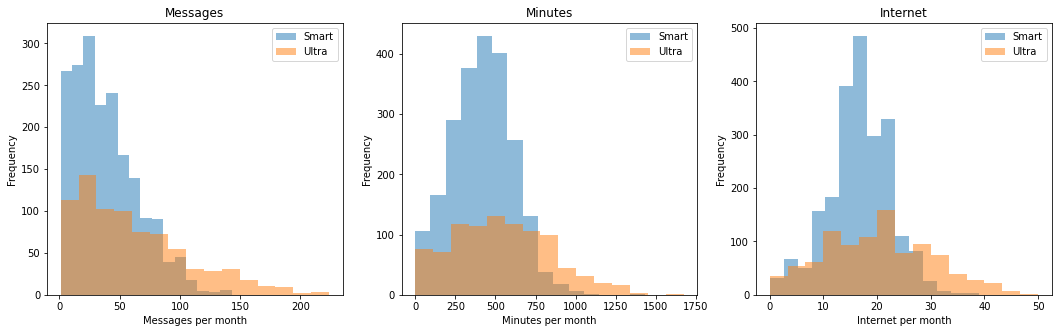

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(['messages', 'minutes', 'internet']):
    ax[i].hist(smart_df[col], alpha=0.5, bins=15)
    ax[i].hist(ultra_df[col], alpha=0.5, bins=15)
    ax[i].legend(['Smart', 'Ultra'])
    ax[i].title.set_text(col.capitalize())
    ax[i].set_xlabel(col.capitalize() + ' per month')
    ax[i].set_ylabel('Frequency')

plt.show()

#### Посчитайте среднее количество, дисперсию и стандартное отклонение.


In [34]:
# сделаем сводную таблицу для среднего и стандартного отклонения сообщений, интернета и минут по каждому тарифу
tariff_df = grouped_df.pivot_table(index='tariff', values=['messages', 'internet', 'minutes'], aggfunc=['mean', 'std', 'var'])
tariff_df = tariff_df.round(1)
tariff_df

mean                       std                       var           \
       internet messages minutes internet messages minutes internet messages   
tariff                                                                         
smart      16.7     38.7   419.1      5.9     26.8   189.3     34.5    717.6   
ultra      20.2     61.2   545.5      9.9     45.9   306.9     98.9   2109.7   

                 
        minutes  
tariff           
smart   35844.2  
ultra   94203.4

#### Посчитаем сколько трафика нужно каждому пользователю в месяц 

In [35]:
# пройдёмся по каждому тарифу
for indx_1 in ['smart', 'ultra']:
    # для каждойго значения "плюс три сигмы" и "минус три сигмы"
    for indx_2 in ['std_3_sigma_plus', 'std_3_sigma_minus']:
        # посчитаем для сообщений, минут и интернета
        for indx_3 in ['internet', 'messages', 'minutes']:
            # если "три сигмы ПЛЮС", то в формуле используем СЛОЖЕНИЕ
            if indx_2 == 'std_3_sigma_plus':
                tariff_df.loc[indx_1, (indx_2, indx_3)] = round(tariff_df.loc[indx_1, ('mean', indx_3)] +
                                                          3 * tariff_df.loc[indx_1, ('std', indx_3)], 1)
            # если "три сигмы МИНУС", то в формуле используем ВЫЧИТАНИЕ
            else:
                # если значение "три сигмы минус" больше нуля
                if round(tariff_df.loc[indx_1, ('mean', indx_3)] - 3 * tariff_df.loc[indx_1, ('std', indx_3)], 1) > 0:
        
                    tariff_df.loc[indx_1, (indx_2, indx_3)] = round(tariff_df.loc[indx_1, ('mean', indx_3)] -
                                                              3 * tariff_df.loc[indx_1, ('std', indx_3)], 1)
                # если значение "три сигмы минус" меньше нуля
                else:
                    tariff_df.loc[indx_1, (indx_2, indx_3)] = np.NaN
tariff_df

mean                       std                       var           \
       internet messages minutes internet messages minutes internet messages   
tariff                                                                         
smart      16.7     38.7   419.1      5.9     26.8   189.3     34.5    717.6   
ultra      20.2     61.2   545.5      9.9     45.9   306.9     98.9   2109.7   

                std_3_sigma_plus                  std_3_sigma_minus           \
        minutes         internet messages minutes          internet messages   
tariff                                                                         
smart   35844.2             34.4    119.1   987.0               NaN      NaN   
ultra   94203.4             49.9    198.9  1466.2               NaN      NaN   

                
       minutes  
tariff          
smart      NaN  
ultra      NaN

Видим, что все значения среднего минус 3 станд. отклонения равны нулям. Удалим эти значения.

In [36]:
tariff_df.dropna(axis=1, inplace=True)
tariff_df

mean                       std                       var           \
       internet messages minutes internet messages minutes internet messages   
tariff                                                                         
smart      16.7     38.7   419.1      5.9     26.8   189.3     34.5    717.6   
ultra      20.2     61.2   545.5      9.9     45.9   306.9     98.9   2109.7   

                std_3_sigma_plus                   
        minutes         internet messages minutes  
tariff                                             
smart   35844.2             34.4    119.1   987.0  
ultra   94203.4             49.9    198.9  1466.2

Округлим значения минут, сообщений и интернета согласно правилам оператора

In [37]:
tariff_df.loc[:, ('std_3_sigma_plus', 'messages')] = round(tariff_df.loc[:, ('std_3_sigma_plus', 'messages')])
tariff_df.loc[:, ('std_3_sigma_plus', 'minutes')] = np.ceil(tariff_df.loc[:, ('std_3_sigma_plus', 'minutes')])
tariff_df.loc[:, ('std_3_sigma_plus', 'internet')] = np.ceil(tariff_df.loc[:, ('std_3_sigma_plus', 'internet')])
tariff_df

mean                       std                       var           \
       internet messages minutes internet messages minutes internet messages   
tariff                                                                         
smart      16.7     38.7   419.1      5.9     26.8   189.3     34.5    717.6   
ultra      20.2     61.2   545.5      9.9     45.9   306.9     98.9   2109.7   

                std_3_sigma_plus                   
        minutes         internet messages minutes  
tariff                                             
smart   35844.2             35.0    119.0   987.0  
ultra   94203.4             50.0    199.0  1467.0

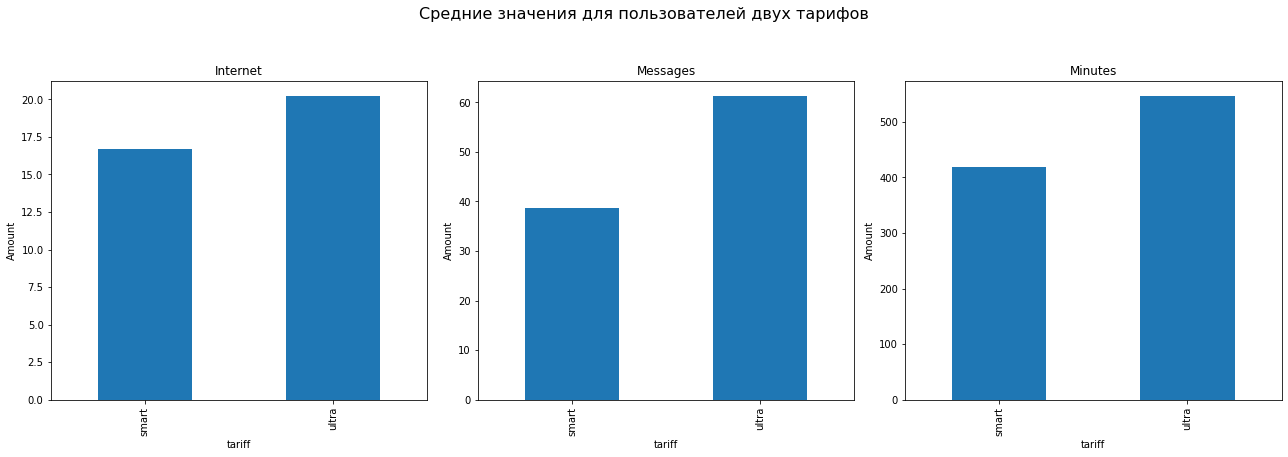

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(['internet', 'messages', 'minutes']):
    tariff_df.loc[:, ('mean', col)].plot(ax=ax[i], kind='bar')
    ax[i].title.set_text(col.capitalize())
    ax[i].set_ylabel('Amount')

fig.suptitle("Средние значения для пользователей двух тарифов", fontsize=16, y=1.05)
fig.tight_layout()
plt.show()

**Промежуточный вывод:** по гистограммам использования сообщений для обоих тарифов видно, что они имеют нормальное распределение, но сильно смещены влево. Минуты для пользователей обоих тарифов так же имеют нормальное распределение и тоже смещены влево, но уже намного слабее. То же самое и для интернета, но уже с совсем маленьким смещением влево. Данное смещение говорит нам о том, что много пользователей используют довольно маленькое кол-во сообщений, в то же время, они чаще звонят и в основном используют интернет. Пользователей, не использующих интернет совсем мало.

По расчётам, средний пользователь тарифа `smart` использует:
- 17 ГБ трафика
- 38 сообщений
- 420 минут разговоров

По расчётам, средний пользователь тарифа `ultra` использует:
- 20 ГБ трафика
- 61 сообщение
- 545 минут разговоров

По расчётам, для 99% пользователей тарифа `ultra` хватает:
- 199 сообщений
- 1467 минут разговоров
- 50 ГБ интернет трафика

По расчётам, для 99% пользователей тарифа `smart` хватает:
- 119 сообщений
- 987 минут разговоров
- 35 ГБ интернет трафика

По расчётам, для 99% пользователей тарифа `ultra` хватает:
- 199 сообщений
- 1467 минут разговоров
- 50 ГБ интернет трафика

# Проверка гипотез

- **средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;**
- **средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

**Пороговое значение alpha задайте самостоятельно.**

## Проверим гипотезу о разности выручки пользователей тарифов «Ультра» и «Смарт»

**Нулевая гипотеза:** - выручки пользователей тарифов «Ультра» и «Смарт» равны

**Альтернативная гипотеза** - выручки пользователей тарифов «Ультра» и «Смарт» НЕ равны

Для проверки гипотез используем "Гипотезу о равенстве средних двух генеральных совокупностей".

In [39]:
#считаем среднюю выручку по всем клиентам для тарифов "Ультра" и "Смарт"
ultra_client_revenue = ultra_df.groupby('user_id')[['monthly_revenue']].mean()
smart_client_revenue = smart_df.groupby('user_id')[['monthly_revenue']].mean()

Сравним дисперсию двух совокупностей. Дисперсия по клиентам тарифа "Смарт" больше в почти 4 раза. Будем использовать параметр `equal_var=False`

In [40]:
var_smart = round(np.var(smart_client_revenue['monthly_revenue'], ddof=1))
var_ultra = round(np.var(ultra_client_revenue['monthly_revenue'], ddof=1))

print(f'Дисперсия дохода по клиентам тарифа "Смарт" = {var_smart}')
print(f'Дисперсия дохода по клиентам тарифа "Ультра" = {var_ultra}')

Дисперсия дохода по клиентам тарифа "Смарт" = 396913
Дисперсия дохода по клиентам тарифа "Ультра" = 107553


**Проверяем гипотезу**

In [41]:
alpha = 0.05
results = st.ttest_ind(smart_client_revenue, ultra_client_revenue, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  [2.76859775e-50]
Отвергаем нулевую гипотезу


## Проверим гипотезу о разности выручки пользователей из Москвы и из других регионов

**Нулевая гипотеза:** - выручки пользователей из Москвы и из других регионов равны

**Альтернативная гипотеза** - выручки пользователей из Москвы и из других регионов НЕ равны

Для проверки гипотез используем "Гипотезу о равенстве средних двух генеральных совокупностей". Т.к. наши совокупности малы и помещаются в оперативную память, мы просто сравним их средние значение между собой.

In [42]:
# Сгруппируем данные по id клиента и посчитаем среднюю выручку с каждого клиента, добавим каждому из клиентов его город.
client_df = grouped_df.groupby('user_id')[['monthly_revenue']].mean()
client_df = client_df.merge(users[['city', 'user_id']], on='user_id', how='left')
client_df.head()

,user_id,monthly_revenue,city
0,1000,1950.000000,Краснодар
1,1001,950.000000,Москва
2,1002,1092.857143,Стерлитамак
3,1003,1950.000000,Москва
4,1004,1950.000000,Новокузнецк


Сделаем 2 отдельных датасета:
- для клиентов из Москвы
- для клиентов не из Москвы (выборку с равным кол-вом записей предыдущему датасету)

In [43]:
moscow_client_df = client_df[client_df.city == 'Москва']
regions_client_df = client_df[client_df.city != 'Москва']

Сравним дисперсию двух совокупностей. Дисперсия по доходу по клиентам из Москвы и регионов не очень большая. Будем использовать параметр `equal_var=True`

In [44]:
msc_var = round(np.var(moscow_client_df['monthly_revenue'], ddof=1))
oth_var = round(np.var(regions_client_df['monthly_revenue'], ddof=1))

print(f'Дисперсия дохода по клиентам из Москвы = {msc_var}')
print(f'Дисперсия дохода по клиентам из регионов = {oth_var}')

Дисперсия дохода по клиентам из Москвы = 378826
Дисперсия дохода по клиентам из регионов = 431571


**Проверяем гипотезу**

In [45]:
alpha = 0.05
results = st.ttest_ind(moscow_client_df['monthly_revenue'], regions_client_df['monthly_revenue'], equal_var = True)

print('p-значение: ', round(results.pvalue, 2))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.35
Не получилось отвергнуть нулевую гипотезу


Поясните:

как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

# Дополнение

In [46]:
# Создадим датафрейм со значениями всей выручки по двум тарифам
total_revenue = {'Ultra' : [ultra_df.groupby('user_id')[['monthly_revenue']].sum().sum()[0]], 'Smart' : [smart_df.groupby('user_id')[['monthly_revenue']].sum().sum()[0]]}
total_revenue = pd.DataFrame.from_dict(total_revenue).T
total_revenue = total_revenue.rename(columns={0: 'total_revenue'})
total_revenue

,total_revenue
Ultra,2058000.0
Smart,3000151.0


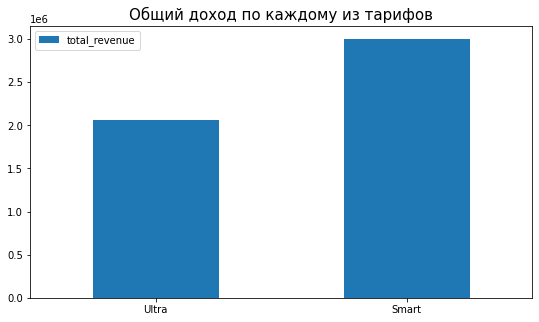

In [47]:
total_revenue.plot(kind='bar', rot=0, figsize=(9, 5))
plt.title('Общий доход по каждому из тарифов', fontsize=15)
plt.show()

# Общий вывод

**Общий вывод**:
В данном проекте были исследованы данные клиентов мобильного оператора. Клиенты делятся по двум тарифам "Смарт" и "Ультра", которые отличаются стоимостью, кол-вом предоставляемых минут по звонкам, кол-вом сообщений и мобильным трафиком. 

Для каждого клиента были посчитаны такие значения по каждому месяцу:
- кол-во звонков и израсходованных
- кол-во отправленных сообщений
- объем израсходованного интернет-трафика
- помесячная выручка

Клиенты тарифа "Смарт" в среднем тратят меньше минут, сообщений и интернет трафика чем клиенты тарифа "Ультра". Гипотеза о равности выручки по двум тарифам была отвергнута. Клиенты тарифа "Ультра" приносят существенно больше выручки на одного клиента, но их самих в несколько раз меньше. Общая выручка по тарифу "Смарт" на треть выше чем по тарифу "Ультра" за счёт большего кол-ва пользователей.